# Notebook to run an LSTM to predict discharge from a particular basin

## Adapted from the code of this paper: 
Kratzert, F., Klotz, D., Brenner, C., Schulz, K., and Herrnegger, M.: Rainfall–runoff modelling using Long Short-Term Memory (LSTM) networks, Hydrol. Earth Syst. Sci., 22, 6005-6022, https://doi.org/10.5194/hess-22-6005-2018, 2018a.

In [2]:
# Imports
from pathlib import Path
from typing import Tuple, List

import gcsfs
import matplotlib.pyplot as plt
from numba import njit
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import tqdm
import glob

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # This line checks if GPU is available

## Read in data from the CAMELS-GB dataset
### Downloadable here: https://catalogue.ceh.ac.uk/documents/8344e4f3-d2ea-44f5-8afa-86d2987543a9
### Replace the file path with the path to where you have saved the dataset 

In [3]:
df_1001_data = pd.read_csv(r"C:\Users\sebhi\EA_flooding\Flooding_data\CAMELS_GB_data\CAMELS_GB\data\timeseries\CAMELS_GB_hydromet_timeseries_1001_19701001-20150930.csv")

In [4]:
### Change the index of the dataframe to datetime

In [5]:
df_1001_data.date = pd.to_datetime(df_1001_data.date, dayfirst=True)

In [6]:
df_1001_data.index = pd.to_datetime(df_1001_data.date, dayfirst=True, format="%Y/%m/%d")

# Create dataframes of forcings and discharges

In [7]:
df_1001_forcings = df_1001_data[['precipitation', 'pet', 'temperature', 'peti', 'humidity', 'shortwave_rad', 'longwave_rad', 'windspeed']]

In [8]:
df_1001_discharge = df_1001_data[['discharge_spec', 'discharge_vol']]

# Function to reshape data for LSTM

In [9]:
def reshape_data(x: np.ndarray, y: np.ndarray, seq_length: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Reshape matrix data into sample shape for LSTM training.

    :param x: Matrix containing input features column wise and time steps row wise
    :param y: Matrix containing the output feature.
    :param seq_length: Length of look back days for one day of prediction
    
    :return: Two np.ndarrays, the first of shape (samples, length of sequence,
        number of features), containing the input data for the LSTM. The second
        of shape (samples, 1) containing the expected output for each input
        sample.
    """
    num_samples, num_features = x.shape

    x_new = np.zeros((num_samples - seq_length + 1, seq_length, num_features))
    y_new = np.zeros((num_samples - seq_length + 1, 1))

    for i in range(0, x_new.shape[0]):
        x_new[i, :, :num_features] = x[i:i + seq_length, :]
        y_new[i, :] = y[i + seq_length - 1, 0]

    return x_new, y_new

# Create PyTorch friendly dataset

In [10]:
class CamelsTXT(Dataset):
    # Create a dataset which is usable by PyTorch, which includes forcing data (precipitation, temperature etc.) and 
    # discharge data for the basin dataset loaded above.

    def __init__(self, seq_length: int=365,period: str=None,
                 dates: List=None, means: pd.Series=None, stds: pd.Series=None):
        
        # Initialise Dataset containing the data of the basin read in above

        #:param seq_length: (optional) Length of the time window of
        #    meteorological input provided for one time step of prediction.
        
        #:param period: (optional) One of ['train', 'eval']. None loads the 
        #    entire time series.
        
        #:param dates: (optional) List of pd.DateTimes of the start and end date 
        #    of the discharge period that is used.
        
        #:param means: (optional) Means of input and output features derived from
        #    the training period. Has to be provided for 'eval' period. Can be
        #    retrieved if calling .get_means() on the data set.
        
        #:param stds: (optional) Stds of input and output features derived from
        #    the training period. Has to be provided for 'eval' period. Can be
        #    retrieved if calling .get_stds() on the data set.
        
        
        self.seq_length = seq_length
        self.period = period
        self.dates = dates
        self.means = means
        self.stds = stds

        # load data into memory
        self.x, self.y = self._load_data()

        # store number of samples as class attribute
        self.num_samples = self.x.shape[0]

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx: int):
        return self.x[idx], self.y[idx]

    def _load_data(self):
        ### Load input and output data from the forcing and discharge datasets 
        df = df_1001_forcings    
        df['QObs(mm/d)'] = df_1001_discharge.discharge_spec

        
        if self.dates is not None:
            # If meteorological observations exist before start date
            # use these as well. Similiar to hydrological warmup period.
            if self.dates[0] - pd.DateOffset(days=self.seq_length) > df.index[0]:
                start_date = self.dates[0] - pd.DateOffset(days=self.seq_length)
            else:
                start_date = self.dates[0]
            df = df[start_date:self.dates[1]]

        # if training period store means and stds
        if self.period == 'train':
            self.means = df.mean()
            self.stds = df.std()

        # extract input and output features from df dataframe loaded above 
        x = np.array([df['precipitation'].values,
                      df['shortwave_rad'].values,
                      df['temperature'].values,
                      df['peti'].values,
                      df['humidity'].values]).T
        y = np.array([df['QObs(mm/d)'].values]).T

        # normalise data, reshape for LSTM training and remove invalid samples
        # normalisation is done because it speeds up training and allows the model to give appropriate weight to each feature
        x = self._local_normalization(x, variable='inputs')
        x, y = reshape_data(x, y, self.seq_length)

        if self.period == "train":
            # data tidying!
            # Delete all samples where discharge is NaN
            if np.sum(np.isnan(y)) > 0:
                print(f"Deleted some records because of NaNs") 
                x = np.delete(x, np.argwhere(np.isnan(y)), axis=0)
                y = np.delete(y, np.argwhere(np.isnan(y)), axis=0)
            
            # Deletes all records where no discharge was measured (-999)
            x = np.delete(x, np.argwhere(y < 0)[:, 0], axis=0)
            y = np.delete(y, np.argwhere(y < 0)[:, 0], axis=0)
            
            # normalise discharge - same reasons as given above for the inputs
            y = self._local_normalization(y, variable='output')

        # convert arrays to torch tensors
        x = torch.from_numpy(x.astype(np.float32))
        y = torch.from_numpy(y.astype(np.float32))

        return x, y
    
    def _local_normalization(self, feature: np.ndarray, variable: str) -> \
            np.ndarray:
        
        # Normalize input/output features with local mean/std, for reasons given above!

        #:param feature: Numpy array containing the feature(s) as matrix.
        #:param variable: Either 'inputs' or 'output' showing which feature will
        #   be normalized
        #:return: array containing the normalized feature
        
        if variable == 'inputs':
            means = np.array([self.means['precipitation'],
                              self.means['shortwave_rad'],
                              self.means['temperature'],
                              self.means['peti'],
                              self.means['humidity']])
            stds = np.array([self.stds['precipitation'],
                             self.stds['shortwave_rad'],
                             self.stds['temperature'],
                             self.stds['peti'],
                             self.stds['humidity']])
            feature = (feature - means) / stds
        elif variable == 'output':
            feature = ((feature - self.means["QObs(mm/d)"]) /
                       self.stds["QObs(mm/d)"])
        else:
            raise RuntimeError(f"Unknown variable type {variable}")

        return feature

    def local_rescale(self, feature: np.ndarray, variable: str) -> \
            np.ndarray:
        # This is code for rescaling the features back to their original size ('denormalising')
        
        """Rescale input/output features with local mean/std.

        :param feature: Numpy array containing the feature(s) as matrix.
        :param variable: Either 'inputs' or 'output' showing which feature will
            be normalized
        :return: array containing the normalized feature
        """
        if variable == 'inputs':
            means = np.array([self.means['precipitation'],
                              self.means['shortwave_rad'],
                              self.means['temperature'],
                              self.means['peti'],
                              self.means['humidity']])
            stds = np.array([self.stds['precipitation'],
                             self.stds['shortwave_rad'],
                             self.stds['temperature'],
                             self.stds['peti'],
                             self.stds['humidity']])
            feature = feature * stds + means
        elif variable == 'output':
            feature = (feature * self.stds["QObs(mm/d)"] +
                       self.means["QObs(mm/d)"])
        else:
            raise RuntimeError(f"Unknown variable type {variable}")

        return feature

    def get_means(self):
        return self.means

    def get_stds(self):
        return self.stds

# Define the LSTM model

In [11]:
class Model(nn.Module):
    ### Implementation of a single layer LSTM network 
    ### We may want to implement a more complex network soon - but for now, this is ok. And for my terrible laptop!
    
    def __init__(self, hidden_size: int, dropout_rate: float=0.0):
        #Initialize model
        
        #:param hidden_size: Number of hidden units/LSTM cells
        #:param dropout_rate: Dropout rate of the last fully connected   
        #    layer. Default 0.0. 
        # Here dropout is being used for regularisation - we are going to also use it as a Bayesian approximation later on
            
        super(Model, self).__init__()
        self.hidden_size = hidden_size
        self.dropout_rate = dropout_rate
        
        # create required layer
        self.lstm = nn.LSTM(input_size=5, hidden_size=self.hidden_size, 
                            num_layers=1, bias=True, batch_first=True)
        self.dropout = nn.Dropout(p=self.dropout_rate)
        self.fc = nn.Linear(in_features=self.hidden_size, out_features=1)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass through the Network.
        
        :param x: Tensor of shape [batch size, seq length, num features]
            containing the input data for the LSTM network.
        
        :return: Tensor containing the network predictions
        """
        output, (h_n, c_n) = self.lstm(x)
        
        # perform prediction only at the end of the input sequence
        pred = self.fc(self.dropout(h_n[-1,:,:]))
        return pred

# Functions to train and evaluate the LSTM model

In [12]:
def train_epoch(model, optimizer, loader, loss_func, epoch):
    """Train model for a single epoch.

    :param model: A torch.nn.Module implementing the LSTM model
    :param optimizer: One of PyTorchs optimizer classes.
    :param loader: A PyTorch DataLoader, providing the trainings
        data in mini batches.
    :param loss_func: The loss function to minimize.
    :param epoch: The current epoch (int) used for the progress bar
    """
    # set model to train mode (important for dropout)
    model.train()
    pbar = tqdm.notebook.tqdm(loader)
    pbar.set_description(f"Epoch {epoch}")
    # request mini-batch of data from the loader
    for xs, ys in pbar:
        # delete previously stored gradients from the model
        optimizer.zero_grad()
        # push data to GPU (if available)
        xs, ys = xs.to(DEVICE), ys.to(DEVICE)
        # get model predictions
        y_hat = model(xs)
        # calculate loss
        loss = loss_func(y_hat, ys)
        # calculate gradients
        loss.backward()
        # update the weights
        optimizer.step()
        # write current loss in the progress bar
        pbar.set_postfix_str(f"Loss: {loss.item():.4f}")

        
def eval_model(model, loader) -> Tuple[torch.Tensor, torch.Tensor]:
    """Evaluate the model.

    :param model: A torch.nn.Module implementing the LSTM model
    :param loader: A PyTorch DataLoader, providing the data.
    
    :return: Two torch Tensors, containing the observations and 
        model predictions
    """
    # set model to eval mode (important for dropout)
    model.eval()
    obs = []
    preds = []
    # in inference mode, we don't need to store intermediate steps for
    # backprob
    with torch.no_grad():
        # request mini-batch of data from the loader
        for xs, ys in loader:
            # push data to GPU (if available)
            xs = xs.to(DEVICE)
            # get model predictions
            y_hat = model(xs)
            obs.append(ys)
            preds.append(y_hat)
            
    return torch.cat(obs), torch.cat(preds)
        
def calc_nse(obs: np.array, sim: np.array) -> float:
    """Calculate Nash-Sutcliff-Efficiency.

    :param obs: Array containing the observations
    :param sim: Array containing the simulations
    :return: NSE value.
    """
    ### NSE is the standard in hydrology for assessing the predictive skill of models. 1 is perfect, 0 is rubbish!
    
    # only consider time steps, where observations are available
    sim = np.delete(sim, np.argwhere(obs < 0), axis=0)
    obs = np.delete(obs, np.argwhere(obs < 0), axis=0)

    # check for NaNs in observations
    sim = np.delete(sim, np.argwhere(np.isnan(obs)), axis=0)
    obs = np.delete(obs, np.argwhere(np.isnan(obs)), axis=0)

    denominator = np.sum((obs - np.mean(obs)) ** 2)
    numerator = np.sum((sim - obs) ** 2)
    nse_val = 1 - numerator / denominator

    return nse_val

# Prepare for training!

In [13]:
### Feel free to play with these!

hidden_size = 10 # Number of LSTM cells
dropout_rate = 0.4 # Dropout rate of the final fully connected Layer [0.0, 1.0] - used for regularisation and as a way to extract uncertainty (Bayesian approx)
learning_rate = 3e-3 # Learning rate used to update the weights
sequence_length = 365 # Length of the meteorological record provided to the network

###############
# Data set up #
###############

# Training data
start_date = pd.to_datetime("2000-12-09", format="%Y-%m-%d")
end_date = pd.to_datetime("2008-12-08", format="%Y-%m-%d")
ds_train = CamelsTXT(seq_length=sequence_length, period="train", dates=[start_date, end_date])
tr_loader = DataLoader(ds_train, batch_size=256, shuffle=True)

# Validation data. We use the feature means/stds of the training period for normalization
means = ds_train.get_means()
stds = ds_train.get_stds()
start_date = pd.to_datetime("2008-12-09", format="%Y-%m-%d")
end_date = pd.to_datetime("2010-12-08", format="%Y-%m-%d")
ds_val = CamelsTXT(seq_length=sequence_length, period="eval", dates=[start_date, end_date],
                     means=means, stds=stds)
val_loader = DataLoader(ds_val, batch_size=2048, shuffle=False)

# Test data. We use the feature means/stds of the training period for normalization
start_date = pd.to_datetime("2010-12-09", format="%Y-%m-%d")
end_date = pd.to_datetime("2015-09-29", format="%Y-%m-%d")
ds_test = CamelsTXT(seq_length=sequence_length, period="eval", dates=[start_date, end_date],
                     means=means, stds=stds)
test_loader = DataLoader(ds_test, batch_size=2048, shuffle=False)


#########################
# Model, Optimizer, Loss#
#########################

# Here we create our model, feel free 
model = Model(hidden_size=hidden_size, dropout_rate=dropout_rate).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_func = nn.MSELoss()

C:\Users\sebhi\Miniconda3\envs\floods\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Train the model

In [14]:
n_epochs = 50 # Number of training epochs

for i in range(n_epochs):
    train_epoch(model, optimizer, tr_loader, loss_func, i+1)
    obs, preds = eval_model(model, val_loader)
    preds = ds_val.local_rescale(preds.numpy(), variable='output')
    nse = calc_nse(obs.numpy(), preds)
    tqdm.tqdm.write(f"Validation NSE: {nse:.2f}")


Validation NSE: 0.05



Validation NSE: 0.12



Validation NSE: 0.16



Validation NSE: 0.19



Validation NSE: 0.25



Validation NSE: 0.34



Validation NSE: 0.38



Validation NSE: 0.40



Validation NSE: 0.42



Validation NSE: 0.45



Validation NSE: 0.47



Validation NSE: 0.48



Validation NSE: 0.49



Validation NSE: 0.50



Validation NSE: 0.51



Validation NSE: 0.52



Validation NSE: 0.53



Validation NSE: 0.53



Validation NSE: 0.55



Validation NSE: 0.56



Validation NSE: 0.56



Validation NSE: 0.56



Validation NSE: 0.56



Validation NSE: 0.57



Validation NSE: 0.58



Validation NSE: 0.59



Validation NSE: 0.59



Validation NSE: 0.59



Validation NSE: 0.59



Validation NSE: 0.59



Validation NSE: 0.59



Validation NSE: 0.60



Validation NSE: 0.60



Validation NSE: 0.61



Validation NSE: 0.61



Validation NSE: 0.62



Validation NSE: 0.61



Validation NSE: 0.61



Validation NSE: 0.62



Validation NSE: 0.62



Validation NSE: 0.62



Validation NSE: 0.62



Validation NSE: 0.62



Validation NSE: 0.62



Validation NSE: 0.63



Validation NSE: 0.63



Validation NSE: 0.63



Validation NSE: 0.64



Validation NSE: 0.63



Validation NSE: 0.63


# Here we use dropout as a Bayesian approximation to extract uncertainty from the LSTM

### This can be skipped if desired

### For those interested, dropout as a Bayesian approximation paper: https://arxiv.org/abs/1506.02142 
### It's a classic paper!

In [15]:
def predict_model_dropout(model, loader) -> Tuple[torch.Tensor, torch.Tensor]:
    """Evaluate the model.

    :param model: A torch.nn.Module implementing the LSTM model
    :param loader: A PyTorch DataLoader, providing the data.
    
    :return: Two torch Tensors, containing the observations and 
        model predictions
    """
    # set model to train mode (important for dropout - allows uncertainty in predictions)
    model.train()
    obs = []
    preds = []
    # in inference mode, we don't need to store intermediate steps for
    # backprob
    with torch.no_grad():
        # request mini-batch of data from the loader
        for xs, ys in loader:
            # push data to GPU (if available)
            xs = xs.to(DEVICE)
            # get model predictions
            y_hat = model(xs)
            obs.append(ys)
            preds.append(y_hat)
            
    return torch.cat(obs), torch.cat(preds)

### Here we get our LSTM to predict discharge given the flood data 20 times, each of which will provide a different output due to the nature of dropout. We then take the mean and standard deviation of this analysis and plot them.

In [16]:
obs, preds = predict_model_dropout(model, test_loader)
dropout_preds = ds_val.local_rescale(preds.numpy(), variable='output')

In [17]:
for _ in range(19):
    obs, preds = predict_model_dropout(model, test_loader)
    preds = ds_val.local_rescale(preds.numpy(), variable='output')
    dropout_preds = np.concatenate((dropout_preds, preds), axis = 1)

In [18]:
dropout_preds_mean = dropout_preds.mean(axis=1)
dropout_preds_var = dropout_preds.var(axis=1)

# Evaluate test set
### Straight to this if dropout skipped

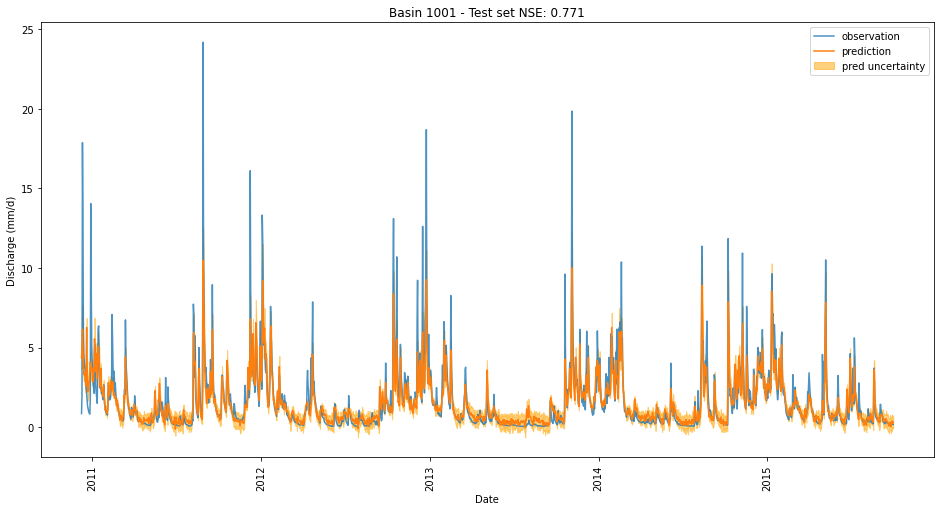

In [19]:
# Evaluate on test set - run this if dropout section skipped
obs, preds = eval_model(model, test_loader)
preds = ds_val.local_rescale(preds.numpy(), variable='output')
obs = obs.numpy()
nse = calc_nse(obs, preds)

# Plot results
start_date = ds_test.dates[0]
end_date = ds_test.dates[1] + pd.DateOffset(days=1)
date_range = pd.date_range(start_date, end_date)
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(date_range, obs, label="observation", alpha = 0.8) #Play around with alpha here to see uncertainty better!
ax.plot(date_range, dropout_preds_mean, label="prediction")  # Replace dropout_preds_mean with preds if dropout section skipped
ax.fill_between(date_range, dropout_preds_mean - np.sqrt(dropout_preds_var), dropout_preds_mean + np.sqrt(dropout_preds_var), alpha=0.5,color='orange', label = 'pred uncertainty') # Hash out this line if dropout section skipped
ax.legend()
ax.set_title(f"Basin 1001 - Test set NSE: {nse:.3f}")
ax.xaxis.set_tick_params(rotation=90)
ax.set_xlabel("Date")
_ = ax.set_ylabel("Discharge (mm/d)")

# Captures the trends - but need to get after the extreme values!